In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('cuda_ad_rgb')

In [2]:
integrator = {
    'type': 'direct_reparam',
}

In [3]:
scene = mi.load_file('../scenes/editing-a-scene/cbox.xml')

In [4]:
img_ref = mi.render(scene, spp=512)
mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [5]:
params = mi.traverse(scene)
key = 'light.vertex_positions'
initial_vertex_positions = dr.unravel(mi.Point3f, params[key])

In [6]:
opt = mi.ad.Adam(lr=0.01)
optKey = 'trans'
opt['trans'] = mi.Point2f(0.1, -0.25)

In [7]:
def apply_transformations(params, opt):
    opt[optKey] = dr.clamp(opt[optKey], -0.5, 0.5)

    trafo = mi.Transform4f.translate([opt[optKey].x, opt[optKey].y, 0.0])

    params[key] = dr.ravel(trafo @ initial_vertex_positions)
    params.update()

In [8]:
# initial state
apply_transformations(params, opt)

img_init = mi.render(scene, seed=0, spp=512)

mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [9]:
iteration_count = 30
spp = 16

In [12]:
loss_hist = []
for it in range(iteration_count):
    # apply mesh transformation
    apply_transformations(params, opt)

    # perform differentiable rendering
    img = mi.render(scene, params, seed=it, spp=spp)

    # evaluate the objective function, gx, L2
    loss = dr.sum(dr.sqr(img - img_ref)) / len(img)

    # backpropagate through the rendering process
    dr.backward(loss)

    # optimizer: take a GDS
    opt.step()

    loss_hist.append(loss)
    print(f"Iteration {it:02d}: error={loss[0]:6f}, trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f}]", end='\r')

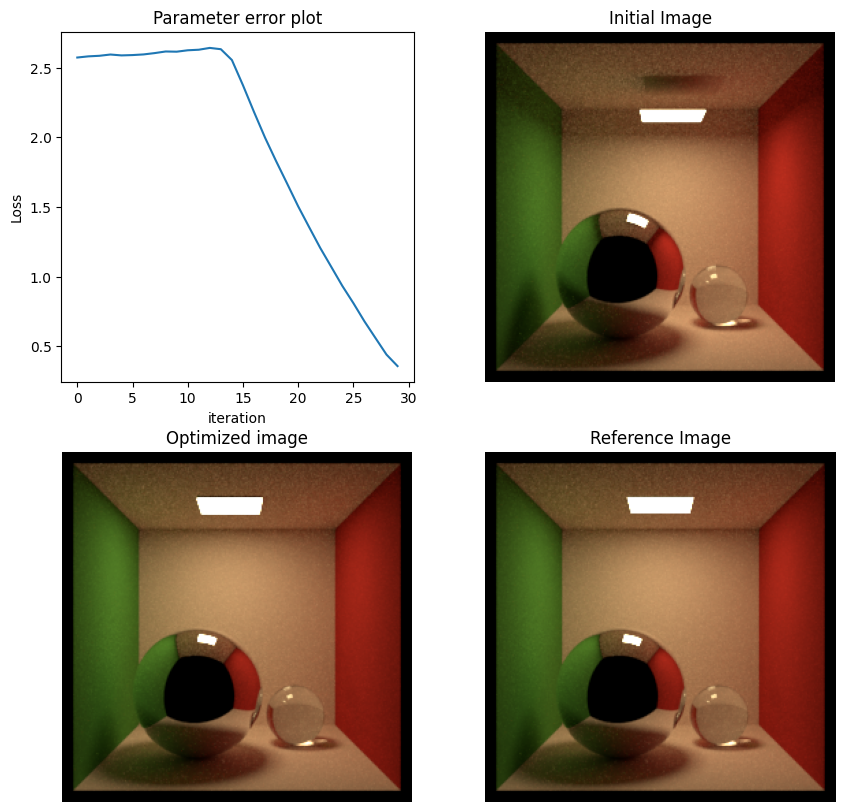

In [11]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].plot(loss_hist)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Parameter error plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=1024)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');